In [126]:
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage
import math
from skimage.transform import resize

In [216]:
n_test = 1
img = imageio.imread('images/image{}.png'.format(n_test))
img_filt = imageio.imread('images/image{}_filt.png'.format(n_test))
img_filt = img_filt[:,:,0]
bg = imageio.imread('images/bg{}.png'.format(n_test))

# Tornar imagem preta e branca

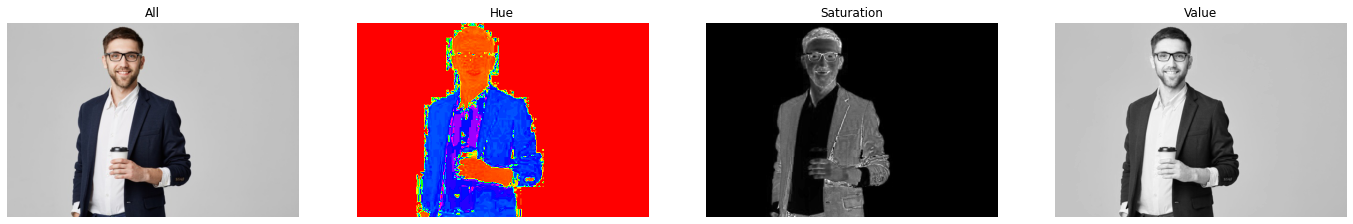

In [218]:
img_hsv = mpl.colors.rgb_to_hsv(img)

plt.figure(figsize=(24, 10))

plt.subplot(241); plt.imshow(img); plt.title('All'); plt.gca().set_axis_off();
plt.subplot(242); plt.imshow(img_hsv[:,:,0], cmap='hsv'); plt.title('Hue'); plt.gca().set_axis_off();
plt.subplot(243); plt.imshow(img_hsv[:,:,1], cmap='gray'); plt.title('Saturation'); plt.gca().set_axis_off();
plt.subplot(244); plt.imshow(img_hsv[:,:,2], cmap='gray'); plt.title('Value'); plt.gca().set_axis_off();

In [221]:
def img_to_bw(img):
  img_hsv = mpl.colors.rgb_to_hsv(img)
  img_bw = img_hsv[:,:,2]

  return img_bw

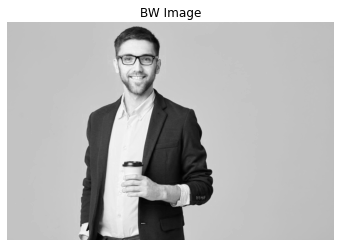

In [222]:
img_bw = img_to_bw(img)
plt.imshow(img_bw, cmap='gray'); plt.title('BW Image'); plt.gca().set_axis_off();

# Filtro LoG (Laplacian of Gaussian)

In [ ]:
def apply_filter(img, W):
    img_filtered = np.zeros(img.shape)

    n = W.shape[0]

    pad = int((n-1)/2)
    
    img_pad = np.pad(img, ((pad, pad),(pad, pad)), mode='symmetric')
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            neighborhood = img_pad[i-pad+pad : i+pad+1+pad, j-pad+pad:j+pad+1+pad]    
            img_filtered[i, j] = np.sum(np.multiply(neighborhood, W)).astype(np.uint8)
            
    return img_filtered

In [ ]:
#Aplicando LoG diretamente
def log_filter(sigma, n):
  W = np.zeros((n,n))
  pad = int((n-1)/2)

  for i in range(n):
    for j in range(n):  
        x = i - pad
        y = j - pad
        aux = (x**2 + y**2)/(2*(sigma**2))
        W[i, j] = (-1/(math.pi*(sigma**4))) * (1 - aux) * math.exp(-aux)

  return W/W.sum()

def apply_log_filter(img, n, sigma):
  W_log = log_filter(sigma, n)
  img_filt = apply_filter(img, W_log)

  return img_filt

In [ ]:
#Aplicando Gaussian + Laplacian
def gaussian_filter(k, sigma):
  arx = np.arange((-k//2) + 1.0, (k//2) +1.0)
  x, y = np.meshgrid(arx, arx)
  filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))

  return filt/np.sum(filt)

def apply_log_filter_2(img, n, sigma):
  W_gauss = gaussian_filter(n, sigma)
  img_filt = apply_filter(img, W_gauss)

  W_lp = np.array([[1, 1, 1],
                   [1, -8, 1],
                   [1, 1, 1]])
  img_filt = apply_filter(img_filt, W_lp)

  return img_filt

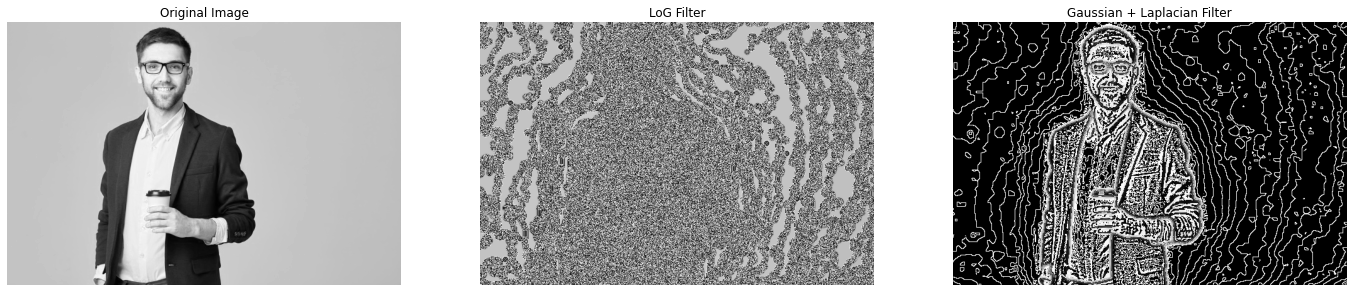

In [ ]:
plt.figure(figsize=(24, 8))

n = 55
sigma = 1

plt.subplot(131); plt.imshow(img_bw, cmap='gray'); plt.title('Original Image'); plt.gca().set_axis_off()

img_log = apply_log_filter(img_bw, n, sigma)
plt.subplot(132); plt.imshow(img_log, cmap='gray'); plt.title('LoG Filter'); plt.gca().set_axis_off()

img_log_2 = apply_log_filter_2(img_bw, n, sigma)
plt.subplot(133); plt.imshow(img_log_2, cmap='gray'); plt.title('Gaussian + Laplacian Filter'); plt.gca().set_axis_off()

# Criação da máscara

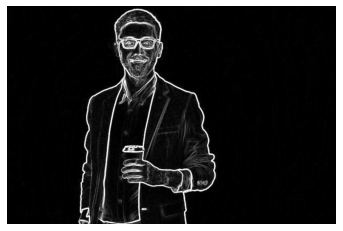

In [154]:
img_filt = imageio.imread('image4_filt.png')
img_filt = img_filt[:,:,0].astype(float)
plt.imshow(img_filt, cmap='gray'); plt.gca().set_axis_off()

In [195]:
def define_mask(img, tolerance=20):
  mask = np.zeros(img.shape)

  xmax = img.shape[0]
  ymax = img.shape[1]

  i = 0
  j = 0

  #percorrer da esquerda pra direita
  while 1:
    if (img[i, j] < tolerance):
      mask[i, j] = 1
      if (j < ymax-1):
        j += 1
      else: 
        if (i < xmax-1):
          i += 1
          j = 0
        else:
          break
    elif (i < xmax-1): 
        i += 1
        j = 0
    else:
      break

  i = xmax-1
  j = ymax-1

  #percorrer da direita pra esquerda
  while 1:
    if (img[i, j] < tolerance):
      mask[i, j] = 1
      if (j > 0):
        j -= 1
      else: 
        if (i > 0):
          i -= 1
          j = ymax-1
        else:
          break
    elif (i > 0): 
        i -= 1
        j = ymax-1
    else:
      break
  
  return mask


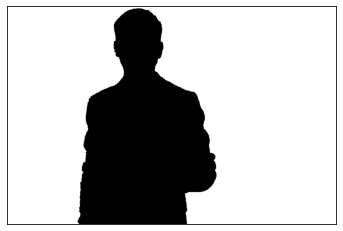

In [166]:
mask = define_mask(img_filt)
plt.imshow(mask, cmap='gray')
plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.show()

# Aplicando a máscara

In [158]:
def apply_mask(img, mask, value=0):

  img = resize(img, mask.shape)
  img_masked = np.zeros(img.shape)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if (mask[i, j] == value):
        img_masked[i, j] == 0
      else:
        img_masked[i, j] = img[i, j]

  return img_masked

In [159]:
bg = imageio.imread('bg1.png')

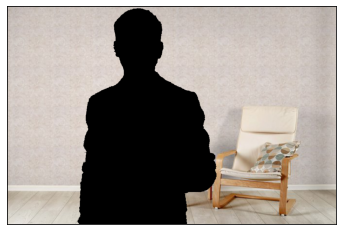

In [168]:
bg_masked = apply_mask(bg, mask, 0)
plt.imshow(bg_masked, cmap='gray')
plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.show()

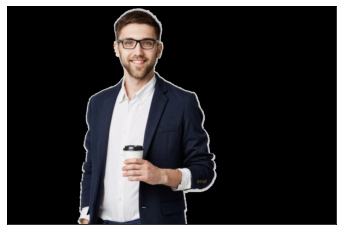

In [167]:
img_masked = apply_mask(img, mask, 1)
plt.imshow(img_masked, cmap='gray')
plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.show()

# Resultado Final

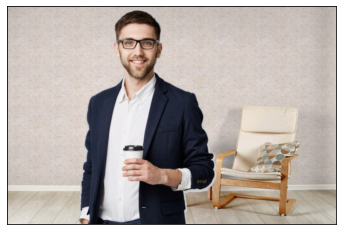

In [169]:
img_final = img_masked + bg_masked
plt.imshow(img_final, cmap='gray')
plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.show()

# Processamento completo

In [201]:
def add_background(img, bg, img_filt, mask_tol=20):
  #TODO: fix LoG filter
  #img_filt = apply_log_filter(img)

  mask = define_mask(img_filt, mask_tol)

  img_masked = apply_mask(img, mask, 1)
  bg_masked = apply_mask(bg, mask, 0)

  img_final = img_masked + bg_masked

  plt.figure(figsize=(24, 12))
  plt.subplot(131); plt.imshow(img, cmap='gray'); plt.gca().set_axis_off(); plt.title('Person Image')
  plt.subplot(132); plt.imshow(bg, cmap='gray'); plt.gca().set_axis_off(); plt.title('Background Image')
  plt.subplot(133); plt.imshow(img_final, cmap='gray'); plt.gca().set_axis_off(); plt.title('Final Image')

  plt.show()



In [202]:
img_filt.shape

(421, 633)

In [203]:
n_test = 1
img = imageio.imread('images/image{}.png'.format(n_test))
img_filt = imageio.imread('images/image{}_filt.png'.format(n_test))
img_filt = img_filt[:,:,0]
bg = imageio.imread('images/bg{}.png'.format(n_test))

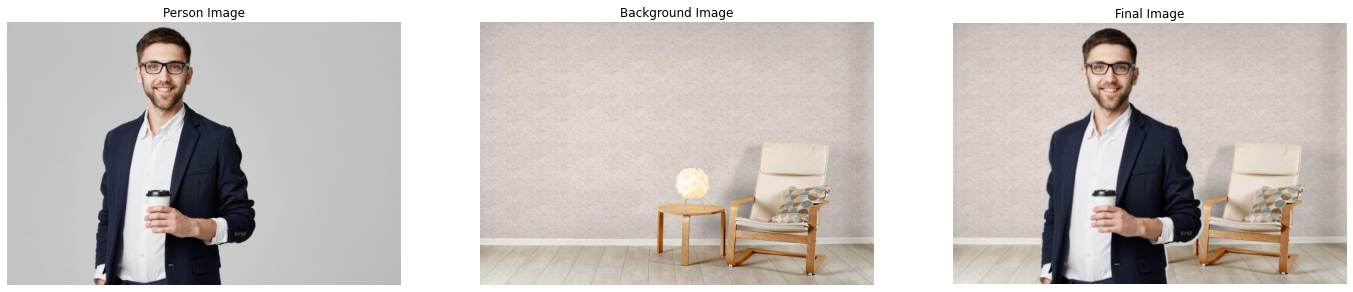

In [204]:
add_background(img, bg, img_filt)

In [212]:
n_test = 2
img = imageio.imread('images/image{}.png'.format(n_test))
img_filt = imageio.imread('images/image{}_filt.png'.format(n_test))
img_filt = img_filt[:,:,0]
bg = imageio.imread('images/bg{}.png'.format(n_test))

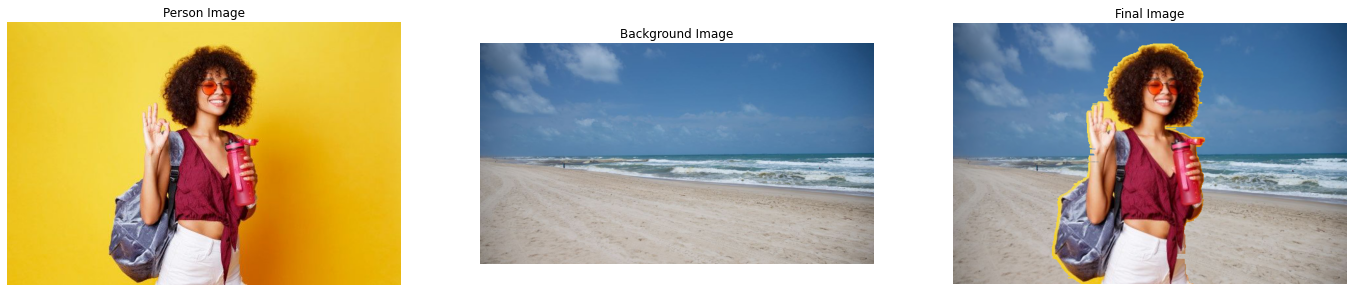

In [215]:
add_background(img, bg, img_filt, mask_tol=30)

In [223]:
n_test = 3
img = imageio.imread('images/image{}.png'.format(n_test))
img_filt = imageio.imread('images/image{}_filt.png'.format(n_test))
img_filt = img_filt[:,:,0]
bg = imageio.imread('images/bg{}.png'.format(n_test))

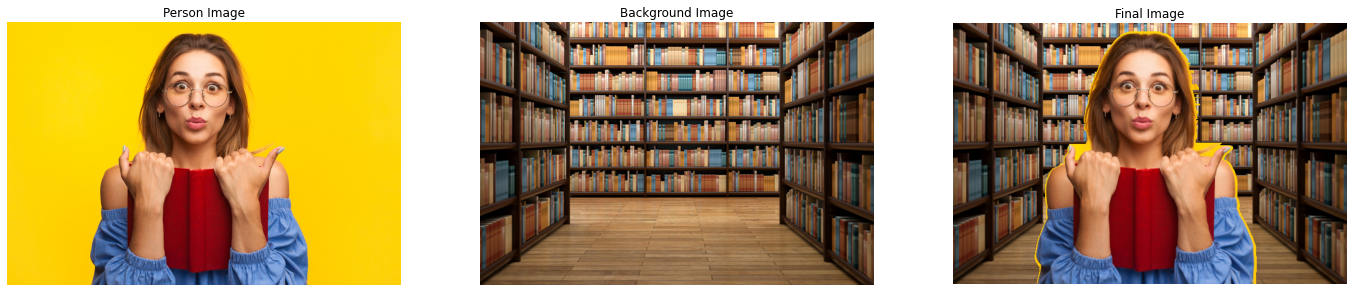

In [224]:
add_background(img, bg, img_filt, mask_tol=50)